In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import warnings

from contrib.handcrafted_data import syn_dataset
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    wrap_lines_into_numpy_batch, torch_to_synthetic_lines
)
from stateful_optimizer import (
    StatefulAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference,
    store_transport_plan,
    strip_confidence_grads,
    save_best_batch
)
from crossing_refiner import CrossingRefinerFull

from matplotlib import pyplot as plt
plt.rc('animation', html='html5')
import matplotlib.animation as animation
from IPython.display import HTML
from geomloss import SamplesLoss
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from vectran.data.graphics_primitives import PrimitiveType
import numpy as np
import torch

torch.manual_seed(4)
np.random.seed(4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Train a neural network for crossings inference

In [11]:
warnings.filterwarnings("ignore")
data_train = [syn_dataset[i] for i in range(100000)]
data_val = [syn_dataset[i] for i in range(20000, 30240)]

KeyboardInterrupt: 

In [ ]:
def make_crossing_rasters(data):
    for i, sample in enumerate(data):
        data[i]['raster'] = 1 - sample['raster']
        vectors = sample['vector'][PrimitiveType.PT_LINE]
        vectors = vectors[vectors.sum(axis=1) != 0][:, :5]
        data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
        data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])
        
    return data

data_train = make_crossing_rasters(data_train)
data_val = make_crossing_rasters(data_val)

In [ ]:
model = CrossingRefinerFull().to(DEVICE)
model.train(True)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([3.0]).to(DEVICE))
mse = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataloader_train = DataLoader(data_train, 32, True)
dataloader_val = DataLoader(data_val, 32, False)

best_val_loss = None
best_weights = None

for epoch in range(50):
    model.train(True)
    
    for batch in tqdm(dataloader_train):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = criterion(pred, crossing_raster) + 0.1 * mse(pred, crossing_raster)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.train(False)
        
    avg_val_loss = 0.
    n_batches = 0
    
    for batch in tqdm(dataloader_val):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = criterion(pred, crossing_raster) + 0.1 * mse(pred, crossing_raster)
        
        avg_val_loss += loss.item()
        n_batches += 1
    
    avg_val_loss /= n_batches
    best_val_loss = best_val_loss or avg_val_loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(epoch, best_val_loss)
        torch.save(model.state_dict(), 'best_crossings.pt')

In [12]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings_good_backup.pt'))
_ = model.train(False)

## Try the new aligner

In [13]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

0


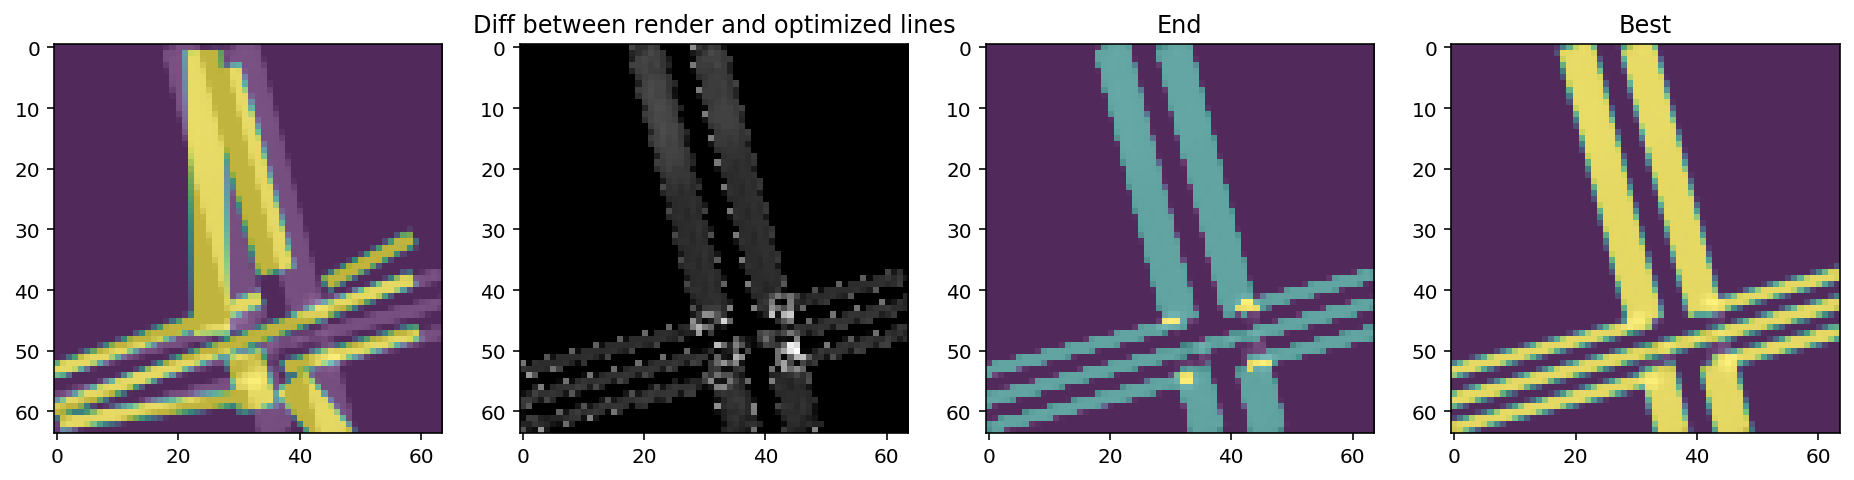

1


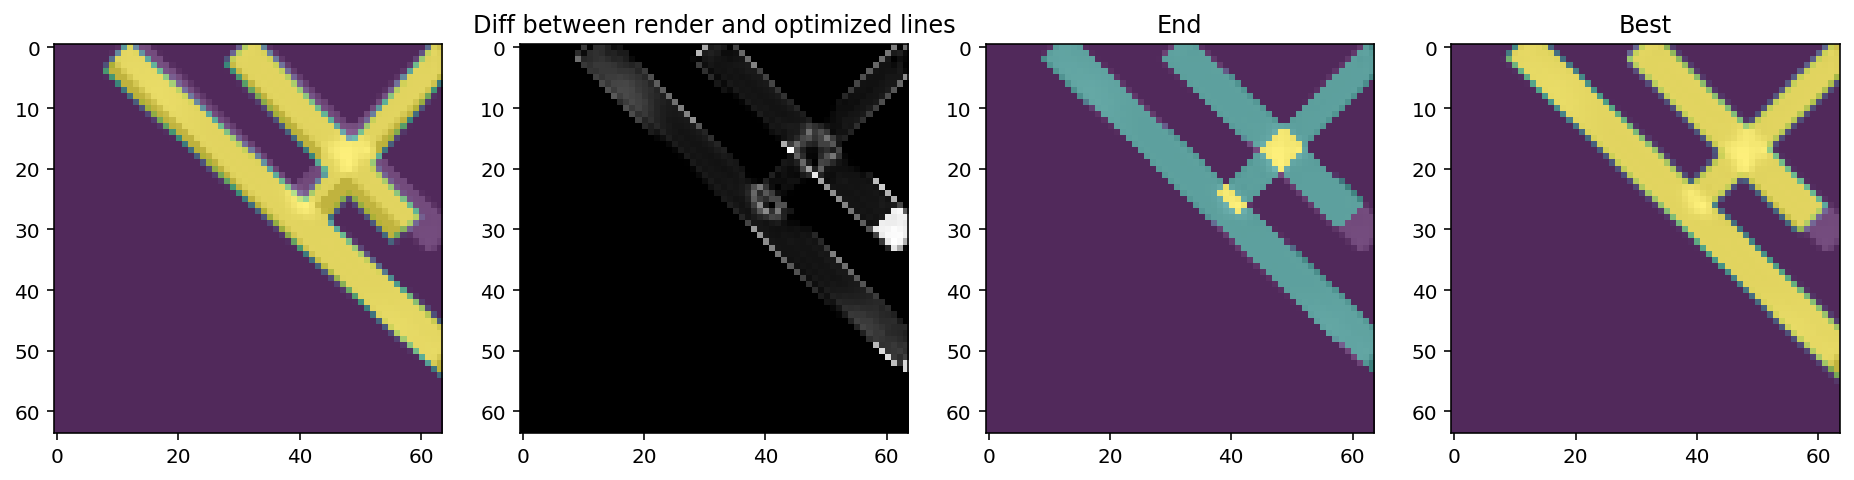

2


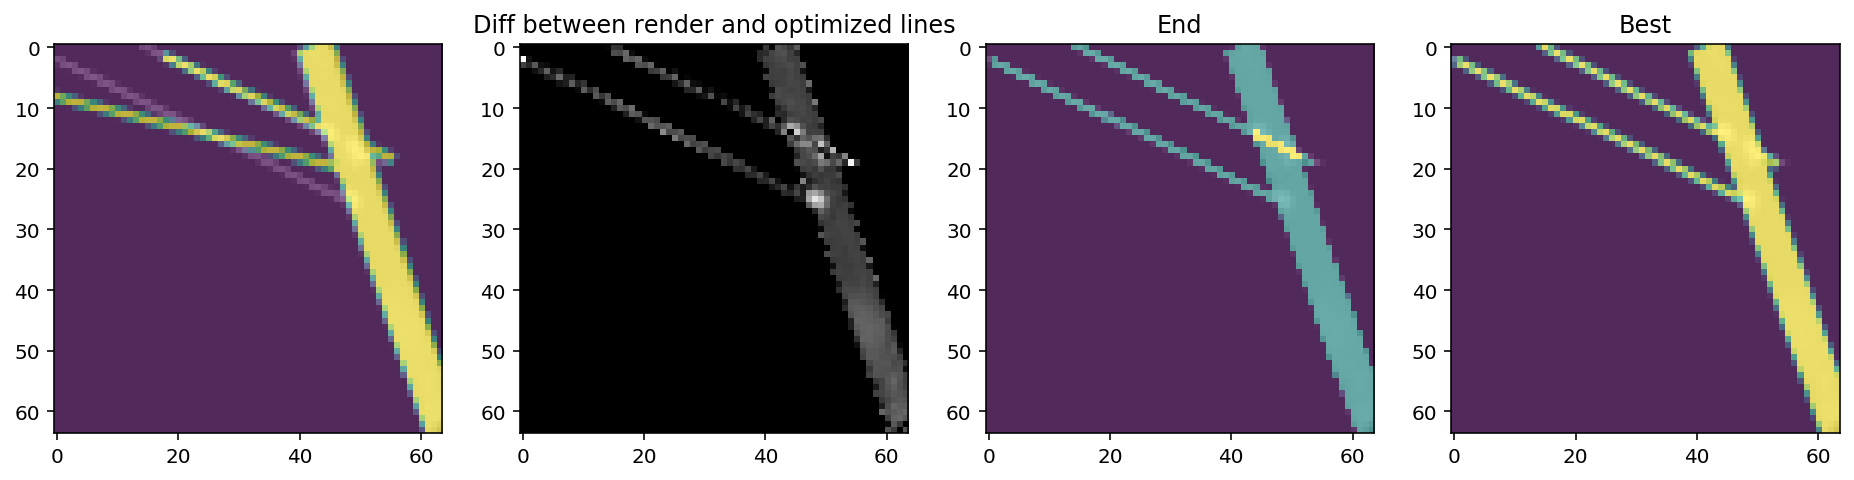

3


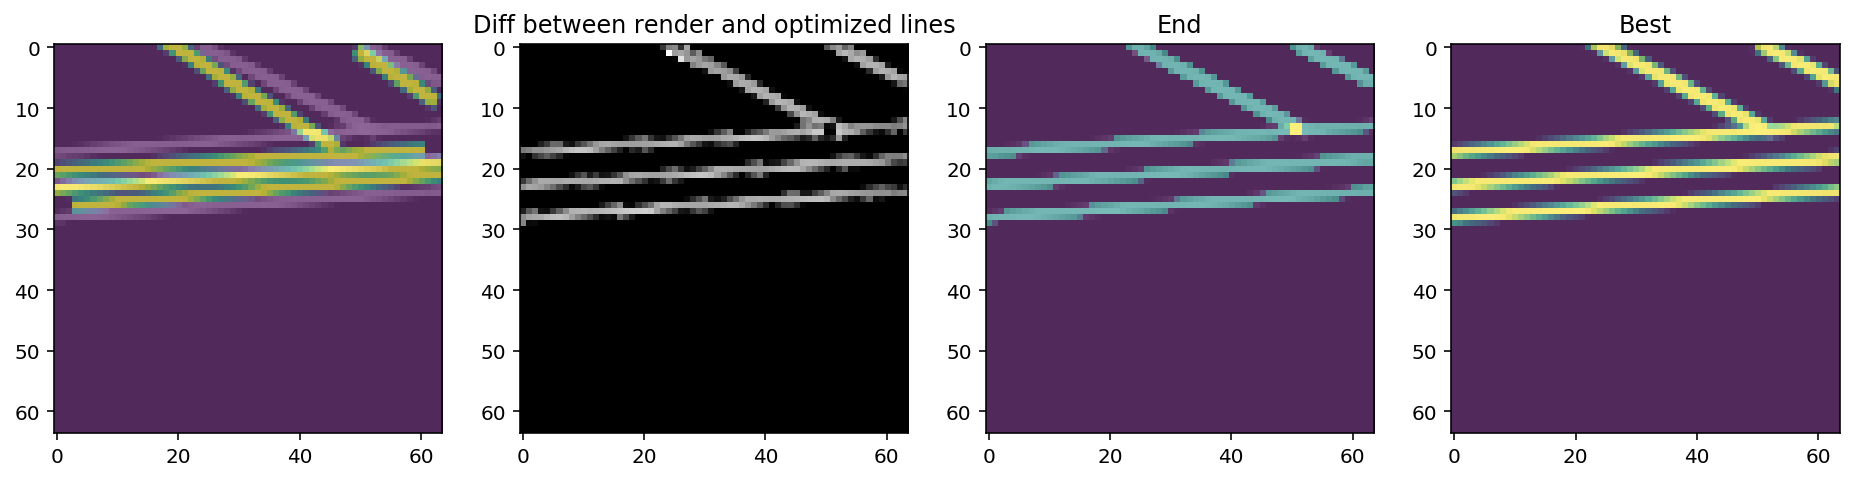

4


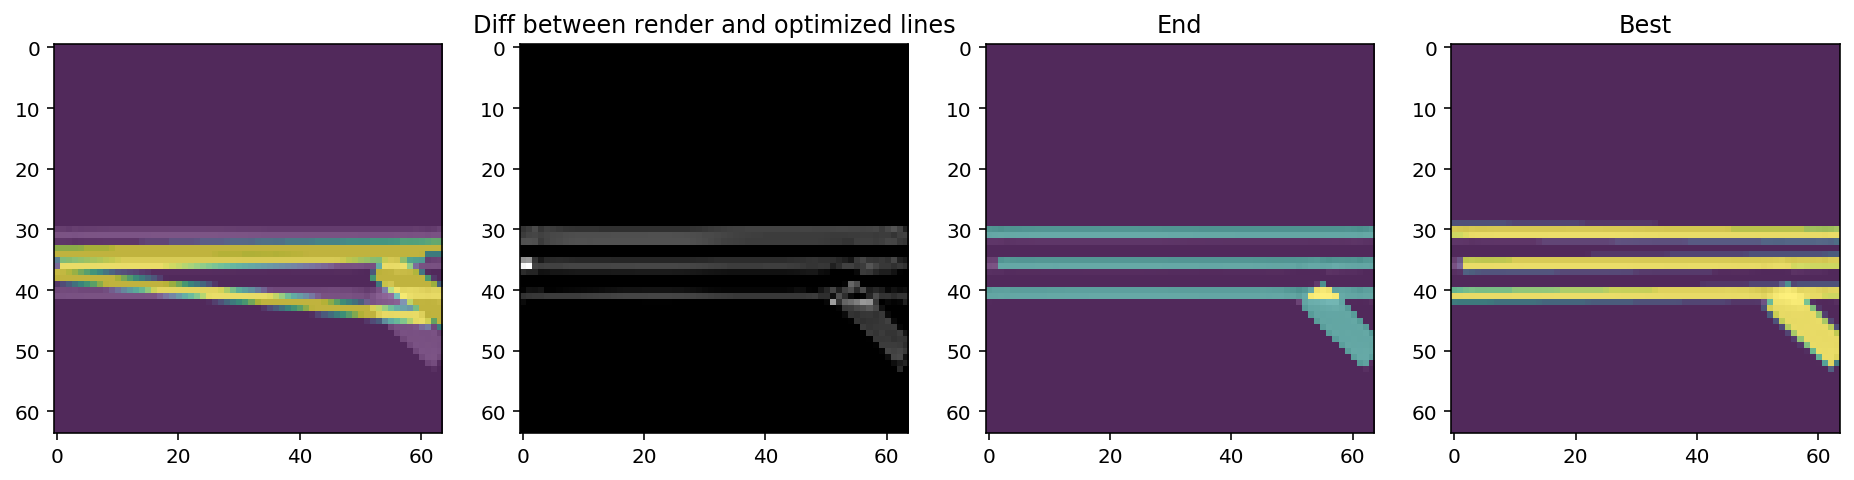

5


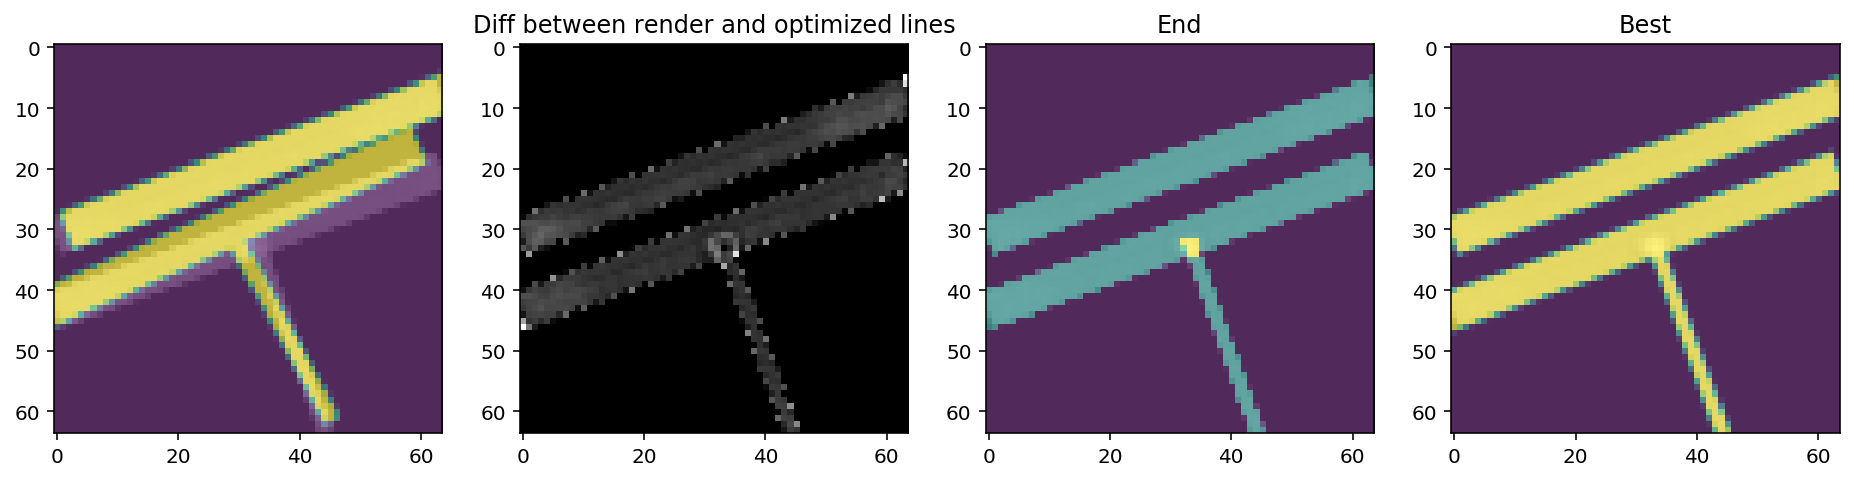

6


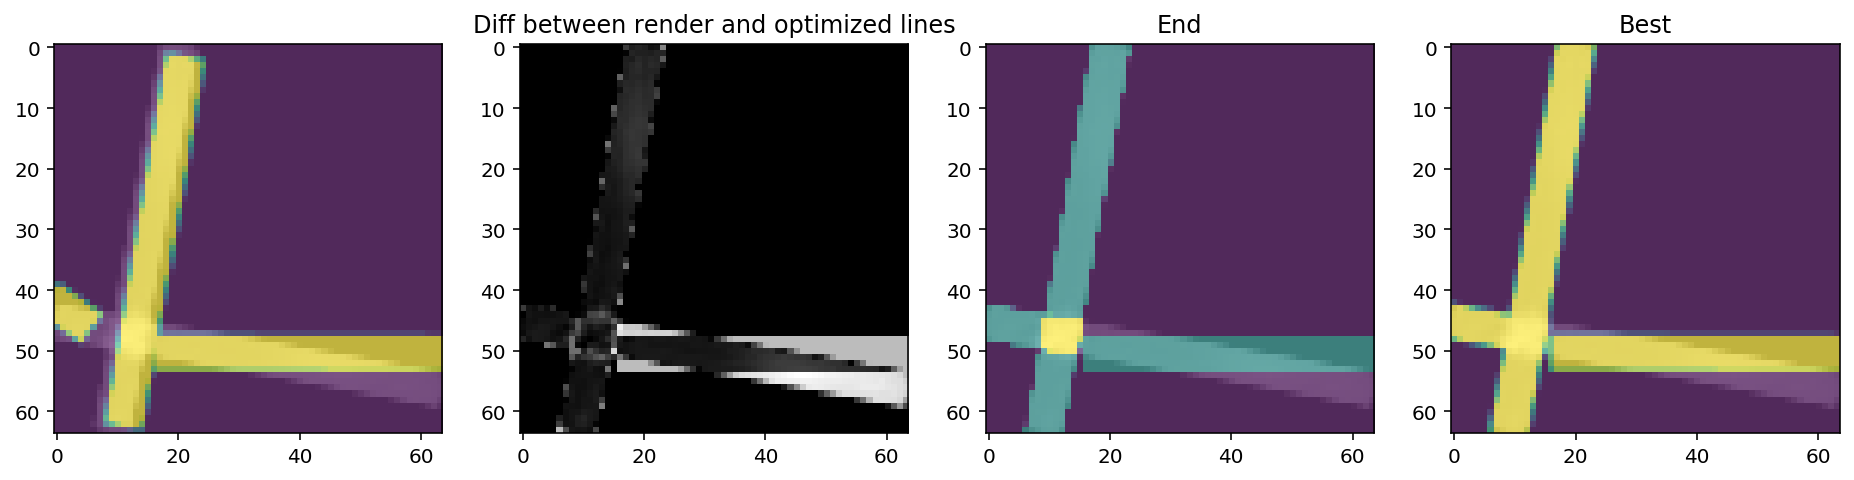

7


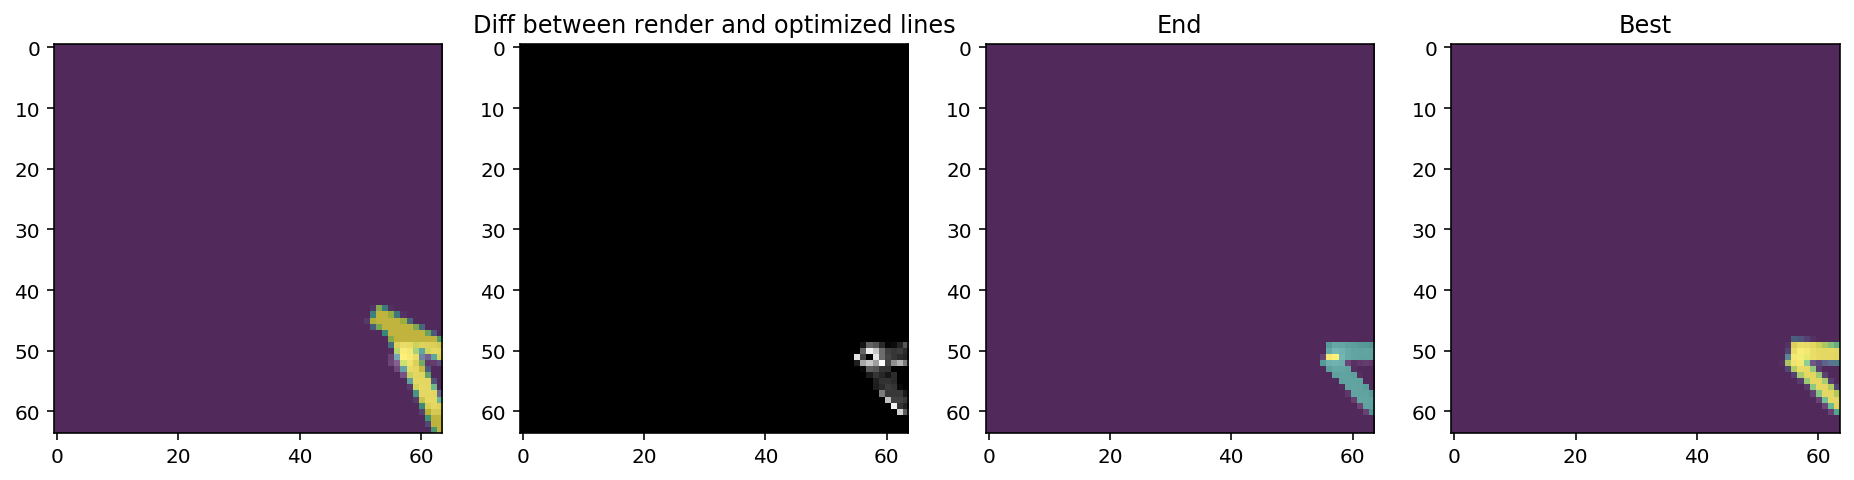

8


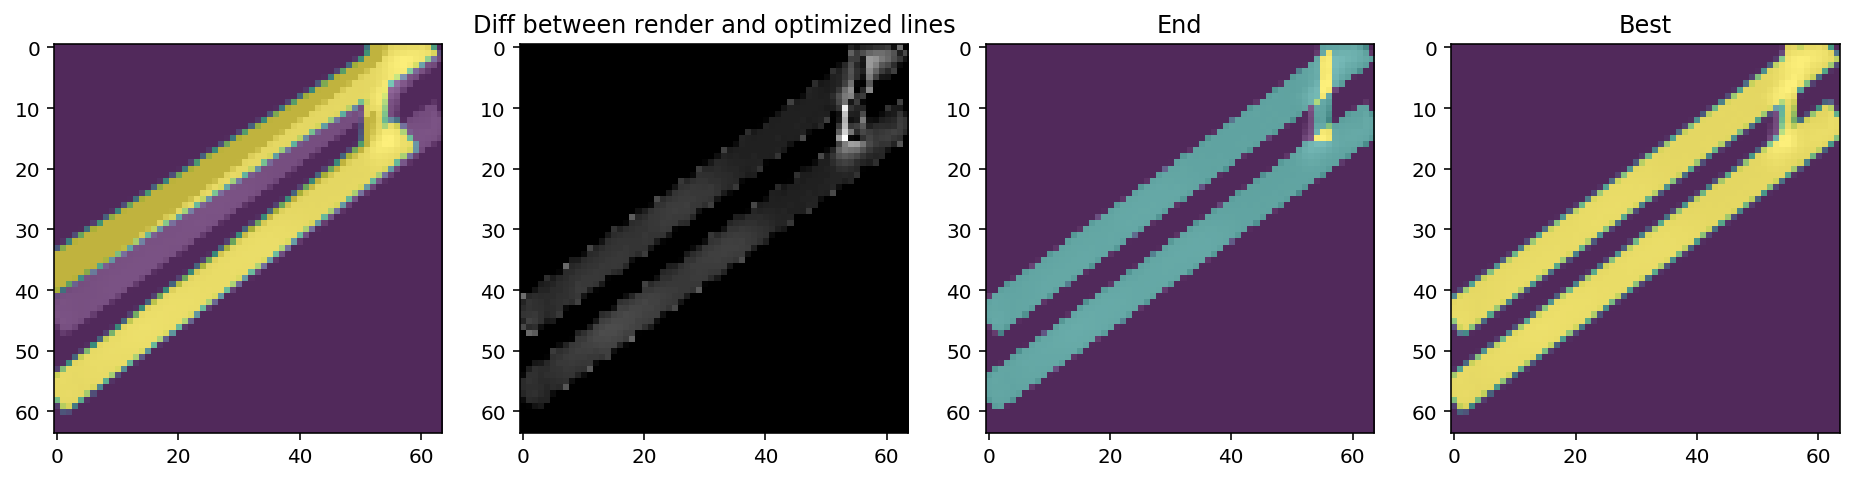

9


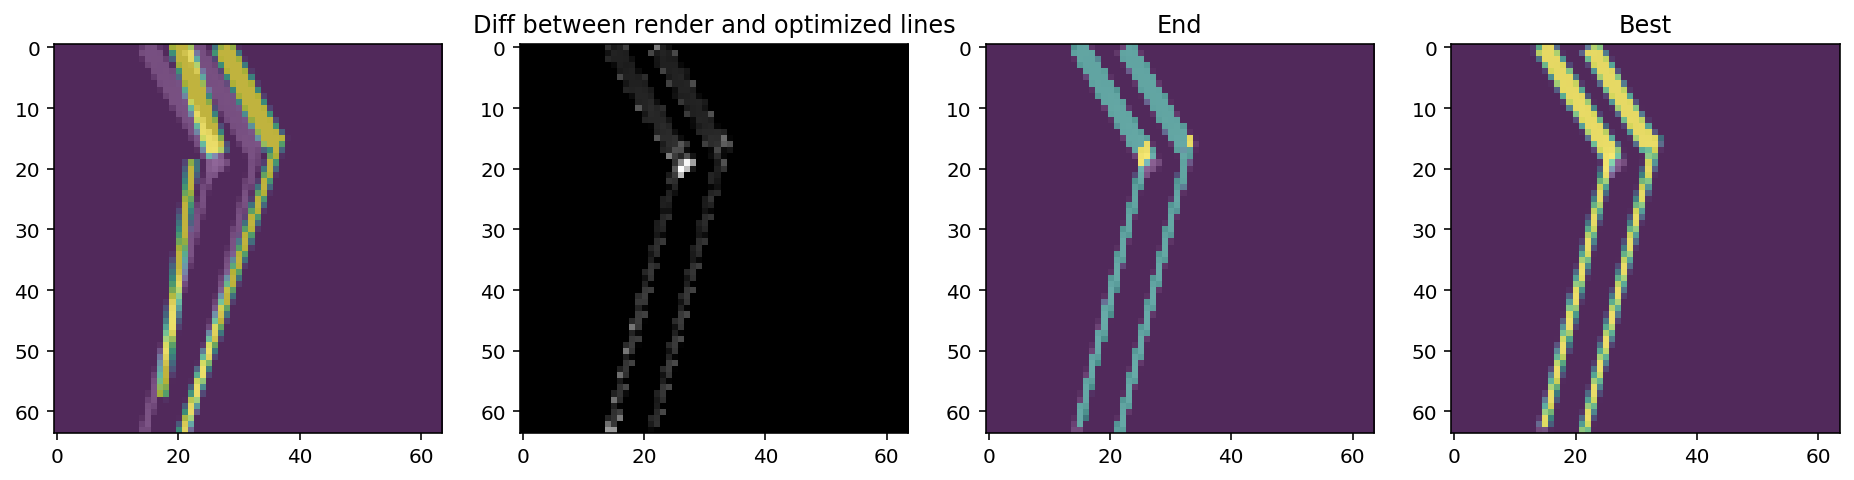

In [14]:
np.random.seed(4)
# np.random.seed(41)


def transform_synthetic_sample(sample):
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    perturbed_batch = torch.from_numpy(perturbed_batch).to(DEVICE)
    
    return {
        'line_batch': perturbed_batch,
        'image': 1 - sample['raster']
    }

def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'].detach().cpu().numpy())


perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)


def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, 4]))


def bound_coordinates(padding=8.):
    def fn(state):
        line_batch = state['current_line_batch']
        return torch.sum(torch.relu(line_batch[:, :, :4] - 64. - padding)) + torch.sum(torch.relu(-padding - line_batch[:, :, :4]))
    return fn


def similar_total_mass(state):
    return torch.abs(2 * torch.sum(state['render']) - torch.sum(state['raster']))


def mae(weight):
    l1_loss = torch.nn.L1Loss()
    def fn(state):
        return weight * l1_loss(state['raster'], state['render'])
    
    return fn


def mse(weight):
    l2_loss = torch.nn.MSELoss()
    def fn(state):
        return weight * l2_loss(state['raster'], state['render'])
    
    return fn


def perceptual_mse(n_convolutions=2):
    l2_loss = torch.nn.MSELoss()
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(0).unsqueeze(0), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(0).unsqueeze(0), n_convolutions)
        result = l2_loss(raster, render)
        return result
    
    return fn


def perceptual_bce(n_convolutions=2, weight=1.0):
    bce = torch.nn.BCEWithLogitsLoss()
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(0).unsqueeze(0), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(0).unsqueeze(0), n_convolutions)
        result = weight * bce(render, raster)
        return result
    
    return fn


def compose(*fns):
    def composition(state):
        for fn in fns:
            fn(state)
            
    return composition


def coords_only_grads(n_steps=200):
    def fn(state):
        strip_confidence_grads(state)
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, 4] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        strip_confidence_grads(state)
        state['current_line_batch'].grad.data[:, :, 4] *= multiplier
    return fn


htmls = []
n_steps = 300

loss = LossComposition()
# loss.add(make_default_loss_fn(bce_schedule=(lambda state: 0.0 if state['current_step'] < n_steps - 200 else 1.0)))
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.6, reach=6.)
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 0.0), ot_loss=ot_loss))
loss.add(perceptual_bce(3))
loss.add(perceptual_bce(4))
# loss.add(perceptual_bce(5))
loss.add(not_too_thin)
# loss.add(mse(1.0))
# loss.add(similar_total_mass)
# loss.add(bound_coordinates(8.))

aligner = None

for random_seed in range(10):
    print(random_seed)
    sample = transform_synthetic_sample(syn_dataset[random_seed])
    image = sample['image']
    # Uncomment the following two lines to use neural crossing inference
    image = torch.from_numpy(image).unsqueeze(dim=0).unsqueeze(dim=1)
    image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
    
    image /= image.max()
    
    line_batch = sample['line_batch']
    
    aligner = StatefulAligner(line_batch, image)
    
    grad_transformer = compose(coords_only_grads(n_steps - 100), reduced_width_lr(1.0))
    init_ot_aligner(aligner, loss_fn=loss,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.25, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam
                    ))
    
#     ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, potentials=True, debias=False)
#     aligner.add_callback(store_transport_plan(ot_loss))
    
    aligner.add_callback(store_render_difference)
    aligner.add_callback(save_best_batch)
#     aligner.add_callback(accumulate_renders)
    
    for _ in range(n_steps):
        aligner.step()
        
    raster = aligner.state['raster'].detach().cpu().numpy()
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    initial = SyntheticPatch.from_lines(torch_to_synthetic_lines(aligner.state['initial_line_batch'][0].detach().cpu())).get_image()
    plt.imshow(initial, alpha=0.6)
    plt.subplot(1, 4, 2)
    plt.title('Diff between render and optimized lines')
    plt.imshow(np.abs(aligner.state['difference'].detach().cpu().numpy()), cmap='gray')
    plt.subplot(1, 4, 3)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('End')
    plt.imshow(aligner.state['render'].detach().cpu().numpy(), alpha=0.6)
    plt.subplot(1, 4, 4)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('Best')
    plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(aligner.state['best_batch'][0].detach().cpu())).get_image(), alpha=0.6)
    plt.show()
    
#     anim = make_animation(raster, aligner.state['renders'])
#     htmls.append(HTML(anim.to_html5_video()))

In [16]:
aligner.state['raster_masses']

tensor([1.8224e-03, 3.2670e-03, 3.4144e-03, 1.2394e-03, 2.4428e-03, 3.3695e-03,
        3.0519e-03, 3.1118e-03, 3.4343e-03, 3.4236e-03, 3.3482e-03, 1.4161e-03,
        3.3277e-03, 3.4555e-03, 3.3592e-03, 1.4381e-03, 7.7314e-04, 3.4250e-03,
        3.3950e-03, 3.3777e-03, 1.9038e-03, 3.1756e-03, 3.3933e-03, 3.3318e-03,
        3.3118e-03, 2.5585e-03, 3.3736e-03, 3.3248e-03, 3.3334e-03, 4.1776e-04,
        3.3960e-03, 3.4147e-03, 3.3919e-03, 2.5610e-03, 3.2832e-03, 3.3536e-03,
        3.3965e-03, 2.9800e-03, 2.1205e-03, 3.4189e-03, 3.4385e-03, 3.4120e-03,
        4.5378e-04, 1.6831e-03, 3.4043e-03, 3.4060e-03, 3.3658e-03, 9.1420e-04,
        3.2890e-03, 3.4336e-03, 3.4722e-03, 3.1434e-03, 3.1815e-03, 3.4214e-03,
        3.3951e-03, 3.3292e-03, 1.2819e-03, 3.4336e-03, 3.4341e-03, 3.4718e-03,
        1.5049e-03, 7.2783e-04, 3.4467e-03, 3.4750e-03, 3.4409e-03, 2.2209e-03,
        3.0332e-03, 3.4649e-03, 3.4615e-03, 3.3468e-03, 2.4941e-03, 3.4762e-03,
        3.4888e-03, 3.4158e-03, 3.5425e-

In [ ]:
np.random.seed(4)

sample = transform_synthetic_sample(syn_dataset[0])
image = sample['image']
# image = aligner.state['']
# Uncomment the following two lines to use neural crossing inference
image = torch.from_numpy(image).unsqueeze(dim=0).unsqueeze(dim=1)
image = model.apply_convolutions(image.to(DEVICE), 3).detach().cpu().numpy()[0][]

print(image.shape)

image /= image.max()
plt.figure(figsize=(6, 6))d
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(aligner.state['raster'].detach().cpu().numpy())
plt.show()

In [ ]:
vc = aligner.state['vector_coords']
rc = aligner.state['raster_coords']

# vc = vc[:, 0] * 64 + vc[:, 1]
# rc = rc[:, 0] * 64 + rc[:, 1]

# vec_idx = vc[aligner.state['transport_plan'].nonzero().T[0]]
# rst_idx = rc[aligner.state['transport_plan'].nonzero().T[1]]

# transport_plan = aligner.state['transport_plan'].view(-1)

In [ ]:
transport_plan = aligner.state['transport_plan']

plt.figure(figsize=(8, 8))
plt.xlim(0, 64)
plt.ylim(0, 64)

max_transported = transport_plan.max().item()

for coords in transport_plan.nonzero():
    i = coords[0].item()
    j = coords[1].item()
    
    start = vc[i].detach().cpu().numpy()
    end = rc[j].detach().cpu().numpy()
    weight = transport_plan[i][j]
    
    plt.plot([start[0], end[0]], [start[1], end[1]], color='C0')
    
plt.show()

In [ ]:
htmls[0]

In [ ]:
htmls[1]

In [ ]:
htmls[2]

In [ ]:
htmls[3]

In [ ]:
htmls[4]

In [ ]:
htmls[5]

In [ ]:
htmls[6]

In [ ]:
htmls[7]

In [ ]:
htmls[8]

In [ ]:
htmls[9]

In [ ]:
htmls[10]

In [ ]:
htmls[11]

In [ ]:
htmls[12]

In [ ]:
htmls[13]

In [ ]:
htmls[14]

In [ ]:
htmls[15]

In [ ]:
htmls[16]

In [ ]:
htmls[17]

In [ ]:
htmls[18]

In [ ]:
htmls[19]

In [ ]:
htmls[20]

In [ ]:
htmls[21]

In [ ]:
htmls[22]

In [ ]:
htmls[23]

In [ ]:
htmls[24]

In [ ]:
htmls[25]

In [ ]:
htmls[26]

In [ ]:
htmls[27]

In [ ]:
htmls[28]

In [ ]:
htmls[29]